필요한 클래스, 라이브러리

In [7]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from transformers import BertTokenizer, TFBertModel, BertModel
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import torch
import warnings
from transformers import BertModel, BertTokenizer
import re
from sklearn.model_selection import GridSearchCV



os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['OMP_NUM_THREADS'] = '1'


okt=Okt()
vectorizer=TfidfVectorizer()

웹 크롤링해서 Df 만들기

In [2]:
url="https://www.safetydata.go.kr/disaster-data/disasterNotification?searchStartDttm=&searchEndDttm=&keyword=&orderBy=&currentPage=1&cntPerPage=12000&pageSize=12000"

response=requests.get(url)

if response.status_code == 200:
    file_path = "disaster_message.html"

    with open(file_path, "w", encoding="utf-8") as file:
        file.write(response.text)

    print(f"HTML content has been downloaded and saved to {file_path}.")
else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")

filename="disaster_message.html"
html=""
with open (filename, 'r', encoding='UTF-8') as file:
    for line in file:
        html+=line

soup=BeautifulSoup(html,'lxml')

rows=soup.find_all('tr')
data_list=[]

for row in rows:
    cols=row.find_all('td')
    cols=[ele.text.strip() for ele in cols]
    data_list.append(cols)

df=pd.DataFrame(data_list, columns=['number','text','time'])

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(df.head())

HTML content has been downloaded and saved to disaster_message.html.
  number  \
0   None   
1  12022   
2  12021   
3  12020   
4  12019   

                                                                                          text  \
0                                                                                         None   
1     폭염경보 지속 발효중이오니, 장시간 야외활동과 한낮 야외작업(논,밭,건설현장 등)을 자제하시고 그늘에서 휴식을 취하는 등 건강관리에 유의바랍니다. [문경시]N   
2  폭염으로 온열질환 발생 가능성이 높습니다. 충분한 물 섭취와 휴식 등 건강에 유의하시고 특히 낮시간대 실외작업, 영농작업 등을 자제하여 주시기 바랍니다.[양산시]N   
3  우리군 폭염경보 발효, 연일 무더위 지속 중▲무더위 취약시간대 논밭작업, 건설현장, 야외활동 등 자제▲폭염안전수칙(물,휴식,그늘)준수 등 건강관리에 유의[고성군]N   
4                  완주지역 폭염경보 발효 중. 야외 활동을 자제하세요, 충분히 물을 마시고 그늘에서 휴식을 취하는 등 건강관리에 유의하세요. [완주군]N   

                  time  
0                 None  
1  2024/07/29 14:49:39  
2  2024/07/29 14:44:22  
3  2024/07/29 14:41:11  
4  2024/07/29 14:39:14  


데이터 개수로 index 바꾸고(과거~현재 순서), 위치(발송처) 정보 분리

In [3]:
df=df.drop(0)
df=df.reset_index(drop=True)

df=df.dropna()
df = df.drop_duplicates()
df['number']=pd.to_numeric(df['number'])
df = df.sort_values(by='number', ascending=True)
df = df.set_index('number')

def extract_location(text):
    if text is None:
        return text, 'NaN'
    start=text.rfind('[')
    end=text.rfind(']')
    if start!=-1 and end!=-1:
        location=text[start+1:end]
        text=text[:start]+text[end+1:]
    else:
        location='NaN'
    return text.strip(), location

df[['text', 'location']] = df['text'].apply(lambda x: pd.Series(extract_location(x)))

pd.set_option('display.max_colwidth', None)

print("Df has completed.")

Df has completed.


text 전처리1: 필요 없어 보이는 문자 제거(주관적 기준)

In [5]:
def preprocessing(text):
    text=text.replace("△", "")
    text=text.replace("\n","")
    text=text.replace("N","")
    text=text.replace("▲","")
    tokens=okt.morphs(text, stem=True)
    return ' '.join(tokens)

df['text']=df['text'].apply(lambda x: preprocessing(x))

print("preprocessing complete.")

preprocessing complete.


텍스트 전처리2: 정규표현식으로 특수문자, 숫자 모두 제거

In [34]:


# Ignore future warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='huggingface_hub')

# Function to clean and preprocess text
def clean_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # text = re.sub(r'\d+', ' ', text)
    text=text.replace("n","")
    return text.lower().strip()

# Assuming df is your DataFrame
df['clean_text'] = df['text'].apply(clean_text)

kobert 모델 이용해 K-means 알고리즘으로 위험도(risk_value) 분류

In [35]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [36]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")
model = BertModel.from_pretrained("monologg/kobert")

# Function to encode texts
def encode_texts(texts, tokenizer, max_length=64):
    return tokenizer(texts.tolist(), max_length=max_length, truncation=True, padding=True, return_tensors='pt')

# Tokenize the cleaned texts
encoded_texts = encode_texts(df['clean_text'], tokenizer, max_length=64)

# Function to get embeddings using pooled output
def get_embeddings(model, encoded_texts, batch_size=8):
    model.eval()  # Set the model to evaluation mode
    embeddings = []
    with torch.no_grad():  # Disable gradient calculation
        for i in range(0, len(encoded_texts['input_ids']), batch_size):
            batch_input_ids = encoded_texts['input_ids'][i:i+batch_size]
            batch_attention_mask = encoded_texts['attention_mask'][i:i+batch_size]
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            pooled_output = outputs.pooler_output
            embeddings.append(pooled_output)
    return torch.cat(embeddings, dim=0)

# Get embeddings
embeddings = get_embeddings(model, encoded_texts, batch_size=8)

# Perform hyperparameter tuning for KMeans
param_grid = {
    'n_clusters': [3, 5, 7, 9],  # Adjust based on expected number of danger levels
    'init': ['k-means++', 'random'],
    'max_iter': [300, 600, 900]
}

kmeans = KMeans(random_state=42)
grid_search = GridSearchCV(kmeans, param_grid, cv=3, n_jobs=-1)
grid_search.fit(embeddings.numpy())

best_kmeans = grid_search.best_estimator_
df['danger_cluster'] = best_kmeans.predict(embeddings.numpy())

# Print the clustering result for the top 20 entries
print(df.head(20))

                                                                                          text  \
number                                                                                           
23       강북구에서 실종된 정동월씨(여,81세)를 찾습니다-160cm,62kg,파란색꽃무늬티,검정바지,검정슬리퍼,빨강모자 \n\nvo.la/hYYMo/ ☎182N   
24                 폭염주의보 발효 중, 논밭 공사장 등 야외활동 자제, 충분한 수분 섭취, 무더위 쉼터 이용 등 건강관리에 각별히 유의하시기 바랍니다.N   
25                                         도로통제 알림. 금일 호우로 2시 30분부터 상동교차로 차량통제중이니 우회하시기 바랍니다.N   
26      코로나19 4급전환 관련 8.31.이후 선별진료소 운영시간 변동(평일 9시~16시,토요일 9시-12시,일요일 미운영) 병의원 전문가용 신속검사 수수료발생N   
27      9.2.(토)새벽~아침 바닷물수위가 높아질 것으로 예상(대조기)▲항포구,저지대등 침수우려지역 안전관리(차량주차금지 등) 철저▲해안가저지대 접근자제등 주의N   
28       통영,거제 호우주의보발효, 예상강수량 30~80mm(많은곳100mm이상), 해안가침수, 너울성파도, 선박사고 등 인명피해가 우려되니 안전에유의바랍니다.N   
29      동구에서 배회중인 이정미씨(여,39세)를 찾습니다-155cm,50kg,단발머리,아이보리반팔티,칠부청바지,흰색신발 \n\nvo.la/YSChL / ☎182N   
30       수성구에서 실종된 이정미씨(여,39세)를 찾습니다-155cm,50kg,단발머리,아이보리반팔티,칠부청바지,흰색신발\n\nvo.la/YSChL / ☎182N   
31            서대문구에서

학습결과 시각화

In [37]:
'''
# Apply t-SNE
embeddings_np = embeddings.numpy()
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)
'''

# Create a DataFrame for visualization
visualization_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
visualization_df['cluster'] = df['danger_cluster']

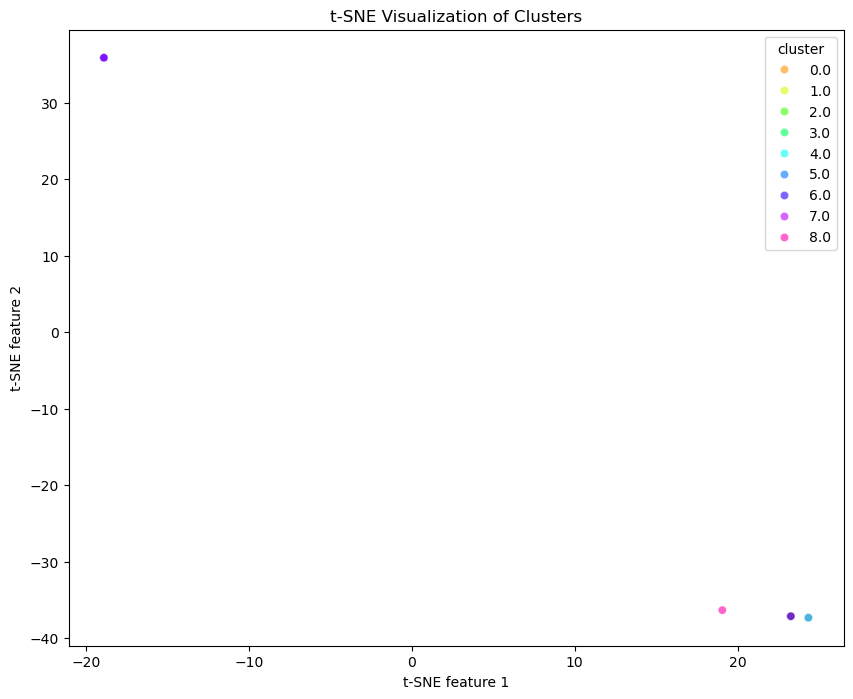

In [38]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='x', y='y',
    hue='cluster',
    palette=sns.color_palette("hsv", len(df['danger_cluster'].unique())),
    data=visualization_df,
    legend="full",
    alpha=0.6
)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.show()

엑셀로 파일 변환

In [39]:
output_file = "risk_value7.xlsx"

df.to_excel(output_file, index=False, engine='openpyxl')

print(f"DataFrame has been exported to {output_file}")

DataFrame has been exported to risk_value7.xlsx


실종자 찾는 안내문자 제외하고 군집화

In [50]:
data = pd.read_csv('risk_value2.csv')
data = data[~data['clean_text'].str.contains('vo la', case=False, na=False)]
data = data[~data['clean_text'].str.contains('찾습니다', case=False, na=False)]

okt = Okt()

def tokenize_korean(text):
    return ' '.join(okt.morphs(text))

data['clean_text'] = data['clean_text'].apply(tokenize_korean)

# risk_value5: 숫자 제거 안 하고 돌린 거: 가장 좋음.
'''
X = vectorizer.fit_transform(data['clean_text'])

kmeans = KMeans(n_clusters=7, random_state=42)
data['cluster'] = kmeans.fit_predict(X)
'''

# Vectorizing with TF-IDF and including bigrams
vectorizer = TfidfVectorizer(stop_words=['바랍니다'], max_features=1000)
X = vectorizer.fit_transform(data['clean_text'])

# Dimensionality Reduction
pca = PCA(n_components=10)
X = pca.fit_transform(X.toarray())

# KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42, init='k-means++')
data['cluster'] = kmeans.fit_predict(X)




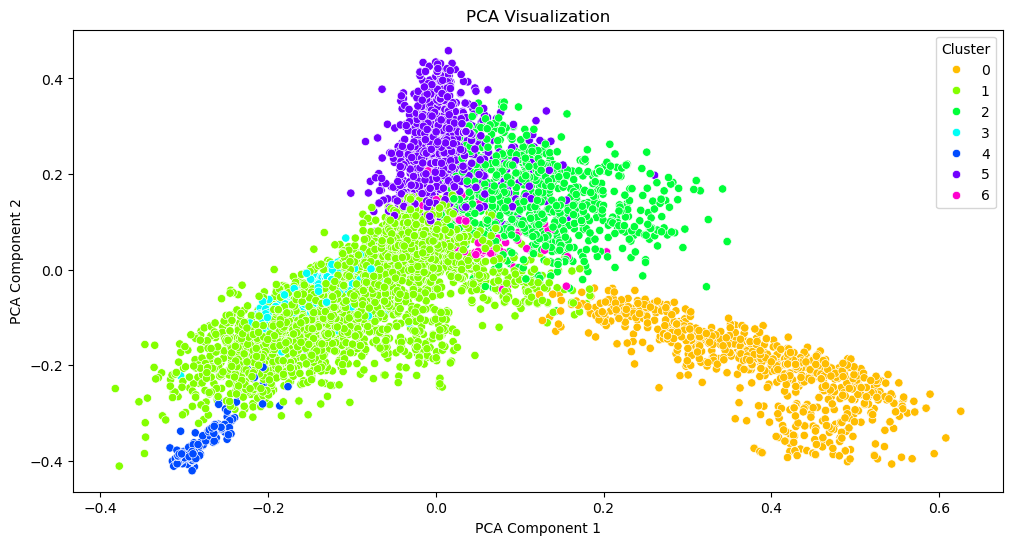

In [48]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['cluster'], palette=sns.color_palette('hsv', 7))
plt.title('PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [49]:
output_file = "risk_value9.xlsx"

data.to_excel(output_file, index=False, engine='openpyxl')

print(f"DataFrame has been exported to {output_file}")

DataFrame has been exported to risk_value9.xlsx
